### Library Imports

Imports standard and specialized libraries required for the breast cancer classification pipeline:

- **General utilities**: `os`, `glob`, `random`, `pandas`, `numpy`
- **Image handling**: `cv2` (OpenCV), `matplotlib` for visualization
- **Progress monitoring**: `tqdm` for progress bars
- **Data processing**: 
  - `sklearn` for stratified splits, label encoding, and evaluation metrics
- **PyTorch**: 
  - Core modules (`torch`, `nn`, `F`) for model building
  - `Dataset`, `DataLoader` for data pipeline
  - `autocast`, `GradScaler` for AMP (Automatic Mixed Precision)
- **Vision models**: `timm` for pretrained model backbones
- **Transforms**: `torchvision.transforms` for augmentation pipelines

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import torch
import pandas as pd
import random
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as skm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

### Configuration Class with Auxiliary Loss Weight

Defines a `CFG` class for centralized configuration of the training pipeline. It includes:

- **Model & Training**:
  - Backbone model from `timm`, input image size, batch size, learning rate, number of epochs and folds.
- **Cross-validation**:
  - Fold selection and random seed for reproducibility.
- **Loss Function**:
  - Option to select Focal Loss.
- **Augmentation Settings**:
  - Horizontal/vertical flips, rotation, and pixel-level augmentations (brightness, contrast, etc.).
- **Auxiliary Learning**:
  - `aux_loss_weight` controls the contribution of auxiliary targets to the total loss. 
    - A value of `0.4` means auxiliary loss contributes 40% to the final loss.

In [2]:
# CONFIGURATION
class CFG:
    model_name = 'tf_efficientnet_b4.ns_jft_in1k'
    img_size = (512, 512)
    batch_size = 16
    
    epochs = 8
    folds = 4
    
    seed = 42
    selected_folds = [0, 1, 2, 3]
    learning_rate = 1e-4
    loss = 'focal'
    augment = True
    hflip = True
    vflip = True
    rot = 2.0
    cont = [0.8, 1.2]
    bri = 0.15
    sat = [0.7, 1.3]
    hue = 0.05
    pixel_aug = 0.90
    aux_loss_weight = 0.4  # (0.4 weight for aux targets (40%): ADJUSTABLE)


### Set Random Seed for Reproducibility

Defines and calls a `set_seed` function to fix randomness across libraries:

- Seeds the Python `random`, `numpy`, and `torch` libraries.
- Ensures deterministic behavior on GPU by configuring cuDNN backend.
- Uses `CFG.seed` as the base seed for consistency.

This ensures that results are reproducible across training runs and hardware setups.

In [3]:
# SEEDING
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(CFG.seed)

### Load and Prepare Training Data with Encoded Auxiliary Targets

- **Load Data**:
  - Reads `trimmed_train.csv` containing image metadata and labels into `train_df`.

- **Image Path Construction**:
  - Ensures `image_id` is a clean string.
  - Adds a new `image_path` column pointing to the ROI image files.

- **Auxiliary Target Processing**:
  - Fills missing `age` values with the mean and discretizes them into 10 quantile bins (0–9).
  - Defines `AUX_TARGETS` for auxiliary learning.
  - Categorical features (e.g., site, view, implant) are label-encoded.
  - `AUX_TARGET_NCLASSES` stores the number of classes per categorical target.

- **Print Target Info**:
  - Displays unique values and class counts for each auxiliary target for verification.


In [4]:
# LOAD TRAIN.CSV
train_df = pd.read_csv("input/trimmed_train.csv")

# CLEAN DATA
train_df['image_id'] = train_df['image_id'].astype(str).str.strip()

def get_image_path(patient_id, image_id):
    return f"input/roi/trimmed_train_images_roi/{patient_id}/{image_id}.png"

train_df['image_path'] = train_df.apply(lambda row: get_image_path(row['patient_id'], row['image_id']), axis=1)


# ENCODE AUX TARGETS
train_df['age'] = train_df['age'].fillna(train_df['age'].mean())
train_df['age'] = pd.qcut(train_df['age'], 10, labels=False).astype(int)
AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'biopsy', 
               'invasive', 'BIRADS', 'density', 'difficult_negative_case', 
               'machine_id', 'age']

CATEGORY_AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'biopsy', 'invasive', 'BIRADS', 'density', 'difficult_negative_case', 'machine_id']
train_df[CATEGORY_AUX_TARGETS] = train_df[CATEGORY_AUX_TARGETS].apply(LabelEncoder().fit_transform)
AUX_TARGET_NCLASSES = train_df[CATEGORY_AUX_TARGETS].max() + 1

for col in AUX_TARGETS:
    uniques = sorted(train_df[col].unique())
    n_classes = train_df[col].nunique()

    print(f"--- {col} ---")
    print(f"Unique labels in data: {uniques}")
    print(f"Number of classes expected: {n_classes}")
    print()

--- site_id ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- laterality ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- view ---
Unique labels in data: [0, 1, 2, 3]
Number of classes expected: 4

--- implant ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- biopsy ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- invasive ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- BIRADS ---
Unique labels in data: [0, 1, 2, 3]
Number of classes expected: 4

--- density ---
Unique labels in data: [0, 1, 2, 3, 4]
Number of classes expected: 5

--- difficult_negative_case ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- machine_id ---
Unique labels in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of classes expected: 10

--- age ---
Unique labels in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of classes expected: 10



### Train-Test Split and Stratified K-Fold Assignment

- **Initial Split**:
  - Divides the dataset into `train_df` (80%) and `test_df` (20%) using stratified sampling on the `cancer` label.
  - Ensures class balance in the test set.
  - Indexes are reset for both splits.

- **Stratified K-Fold Setup**:
  - Applies `StratifiedGroupKFold` cross-validation using:
    - `cancer` for stratification.
    - `patient_id` for grouping to prevent patient-level data leakage.
  - Adds a `fold` column to `train_df` indicating which fold each sample belongs to.

In [5]:
# TRAIN-TEST SPLIT
train_df, test_df = train_test_split(
    train_df,
    test_size=0.20,
    stratify=train_df['cancer'],
    random_state=CFG.seed
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# STRATIFIED K-FOLD
skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
train_df['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(train_df, train_df['cancer'], groups=train_df['patient_id'])):
    train_df.loc[val_idx, 'fold'] = fold

### Compute Probabilistic Evaluation Metrics

Defines `compute_metrics` to evaluate model performance using multiple metrics:

- **Inputs**:
  - `y_pred`: Predicted probabilities.
  - `y_true`: Ground-truth binary labels.
  - `beta`: Weight for recall emphasis in F-beta (default is 2.0 for recall-prioritized pF1).

- **Probabilistic F-beta Score**:
  - Soft F-beta score using raw probabilities (no thresholding).
  - Balances precision and recall, favoring recall due to `beta=2.0`.

- **Thresholded F1**:
  - Iteratively searches for the best threshold from 0.0 to 1.0.
  - Computes F1 score at each threshold and retains the best one.

- **AUC (Area Under ROC Curve)**:
  - Evaluates model's ability to rank positive over negative samples.

- **Returns**:
  - Probabilistic F-beta (`pf_beta`), best F1 score with threshold, AUC, and the best threshold.

In [6]:
def compute_metrics(y_pred, y_true, beta=2.0):
    y_pred = np.clip(y_pred, 0, 1)
    y_true = np.array(y_true)
    eps = 1e-7
    beta_squared = beta ** 2

    # --- Probabilistic F-beta
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()

    pf_beta = (1 + beta_squared) * tp / ((1 + beta_squared) * tp + beta_squared * fn + fp + eps)

    # --- Thresholded F1
    best_thr_f1 = 0.0
    best_thr = None
    for thr in np.linspace(0.0, 1.0, 50):
        bin_pred = (y_pred > thr).astype(np.float32)
        score = skm.f1_score(y_true, bin_pred)
        if score > best_thr_f1:
            best_thr_f1 = score
            best_thr = thr

    # --- AUC
    auc = skm.roc_auc_score(y_true, y_pred)

    return pf_beta, best_thr_f1, auc, best_thr

### Compute Thresholded Classification Metrics

Defines `compute_classification_metrics` to evaluate model predictions at a fixed threshold:

- **Inputs**:
  - `y_pred`: Predicted probabilities.
  - `y_true`: Ground-truth binary labels.
  - `threshold`: Probability threshold for converting predictions to binary labels.

- **Metrics Computed**:
  - `accuracy`
  - `precision` (with `zero_division=0` to safely handle edge cases)
  - `recall`
  - `F1 score`

- **Returns**:
  - A dictionary containing all four classification metrics.

In [7]:
def compute_classification_metrics(y_pred, y_true, threshold):
    
    y_pred_bin = (np.array(y_pred) > threshold).astype(np.float32)
    y_true = np.array(y_true)

    return {
        'acc': skm.accuracy_score(y_true, y_pred_bin),
        'prec': skm.precision_score(y_true, y_pred_bin, zero_division=0),
        'rec': skm.recall_score(y_true, y_pred_bin, zero_division=0),
        'f1': skm.f1_score(y_true, y_pred_bin)
    }

### Distribution of Cancer Labels Across Dataset Splits and Folds

This block prints summaries to verify the balance of cancer labels (`0` and `1`) across various dataset partitions:

- **Overall Distribution**:
  - Shows the count and proportion of each label (`cancer=0` and `cancer=1`) in the full training set.

- **Train vs. Test Split**:
  - Displays absolute and relative distribution of cancer labels in both the training and test sets, confirming stratified splitting.

- **Per-Fold Distribution**:
  - For each fold (from 0 to `CFG.folds - 1`), prints:
    - Total number of samples
    - Count of positive (`cancer=1`) and negative (`cancer=0`) labels
    - Proportion of positive cases

In [8]:
# SUMMARY OF CANCER DIST
print("\nOverall Cancer Label Distribution:")
print(train_df['cancer'].value_counts())
print(train_df['cancer'].value_counts(normalize=True).rename("proportion"))

print("\nTrain/Validation/Test split distribution:")
for subset_name, subset_df in zip(['Train', 'Test'], [train_df, test_df]):
    print(f"{subset_name} Set:")
    print(subset_df['cancer'].value_counts())
    print(subset_df['cancer'].value_counts(normalize=True).rename("proportion"))
    print()

# SUMMARY PER FOLD
print("\nDistribution per Fold in Train:")
for fold in range(CFG.folds):
    fold_data = train_df[train_df['fold'] == fold]
    counts = fold_data['cancer'].value_counts().to_dict()
    total = len(fold_data)
    print(f"Fold {fold}:")
    print(f"  Total: {total}")
    print(f"  Cancer=1: {counts.get(1, 0)} | Cancer=0: {counts.get(0, 0)}")
    print(f"  Ratio: {(counts.get(1, 0) / total):.4f} cancer\n")


Overall Cancer Label Distribution:
cancer
0    4634
1     926
Name: count, dtype: int64
cancer
0    0.833453
1    0.166547
Name: proportion, dtype: float64

Train/Validation/Test split distribution:
Train Set:
cancer
0    4634
1     926
Name: count, dtype: int64
cancer
0    0.833453
1    0.166547
Name: proportion, dtype: float64

Test Set:
cancer
0    1158
1     232
Name: count, dtype: int64
cancer
0    0.833094
1    0.166906
Name: proportion, dtype: float64


Distribution per Fold in Train:
Fold 0:
  Total: 1392
  Cancer=1: 233 | Cancer=0: 1159
  Ratio: 0.1674 cancer

Fold 1:
  Total: 1420
  Cancer=1: 238 | Cancer=0: 1182
  Ratio: 0.1676 cancer

Fold 2:
  Total: 1322
  Cancer=1: 237 | Cancer=0: 1085
  Ratio: 0.1793 cancer

Fold 3:
  Total: 1426
  Cancer=1: 218 | Cancer=0: 1208
  Ratio: 0.1529 cancer



### Setup Device

- Checks if a CUDA-enabled GPU is available.
- If yes, sets `device` to `"cuda"`; otherwise, defaults to `"cpu"`.

In [9]:
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### PyTorch Dataset with Main and Auxiliary Targets

Defines a custom `BreastCancerDataset` that returns both the main binary label and auxiliary targets:

- **Initialization (`__init__`)**:
  - Stores the DataFrame and any image transforms to apply.

- **Length (`__len__`)**:
  - Returns the number of samples in the dataset.

- **Item Retrieval (`__getitem__`)**:
  - Loads the image from the specified path using OpenCV.
  - Validates the image exists; raises an error if not found.
  - Converts image to RGB and resizes to match `CFG.img_size`.
  - Applies optional transforms (e.g., augmentations).
  - Retrieves:
    - `cancer_target`: The main binary label as a float tensor.
    - `aux_targets`: A tensor of auxiliary labels (int64), using `AUX_TARGETS` from config.

- **Return Format**:
  - Returns a tuple: `(image_tensor, (cancer_target, aux_targets))`

In [10]:
# DATASET

class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_path'])
        
        if img is None:
            raise ValueError(f"Image not found: {row['image_path']}")  
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, CFG.img_size[::-1])
        if self.transform:
            img = self.transform(img)

        cancer_target = torch.tensor(row['cancer'], dtype=torch.float32)
        aux_targets = torch.tensor(row[AUX_TARGETS].values.astype(np.int64), dtype=torch.long)
        return img, (cancer_target, aux_targets)

### Multi-Task Breast Cancer Model with Auxiliary Heads

Defines `BCModel`, a PyTorch model for binary classification with auxiliary outputs:

- **Backbone**:
  - Loads a pretrained model from `timm` without a classification head (`num_classes=0`).
  - Extracts feature embeddings from the final layer.

- **Main Cancer Classification Head**:
  - Applies a linear layer (`fc1`) followed by SiLU activation.
  - Outputs a single logit via `fc_cancer` for binary cancer prediction.
  - Uses `.squeeze(1)` to remove singleton output dimension (shape: `[B]`).

- **Auxiliary Heads**:
  - `fc_aux` is a `ModuleList` of linear layers, one for each auxiliary target.
  - Each layer maps from the backbone features to the number of classes in that target.

- **Forward Pass**:
  - Extracts backbone features.
  - Feeds features into:
    - `fc_cancer` head for main task output.
    - All auxiliary heads in parallel.
  - Returns a tuple: `(cancer_output, list_of_aux_outputs)`

In [11]:
class BCModel(nn.Module):
    def __init__(self, model_name, aux_targets_dims):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, in_chans=3)
        self.backbone_dim = self.backbone.num_features

        # Cancer head
        self.fc1 = nn.Linear(self.backbone_dim, 32)
        self.act = nn.SiLU()
        self.fc_cancer = nn.Linear(32, 1)

        # Aux heads
        self.fc_aux = nn.ModuleList([
            nn.Linear(self.backbone_dim, n_classes)
            for n_classes in aux_targets_dims
        ])

    def forward(self, x):
        x = self.backbone(x)

        # Cancer output head
        cancer_feat = self.fc1(x)
        cancer_feat = self.act(cancer_feat)
        cancer_out = self.fc_cancer(cancer_feat).squeeze(1)

        aux_outs = [head(x) for head in self.fc_aux]

        return cancer_out, aux_outs

### Focal Loss for Imbalanced Binary Classification

Defines a custom `FocalLoss` class used to handle class imbalance in binary classification tasks:

- **Parameters**:
  - `alpha`: Balances importance between classes (e.g., gives more weight to positive cases).
      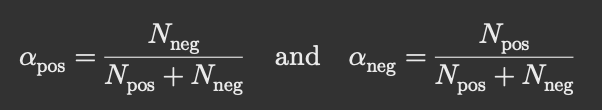
  - `gamma`: Focusing factor that down-weights easy examples and emphasizes harder ones.

- **Forward Pass**:
  - Computes standard binary cross-entropy loss with logits (`reduction='none'`).
  - Converts the loss into probability space using `pt = exp(-BCE_loss)`.
  - Applies the focal loss formula:  

    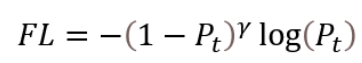
    
  - Returns the mean focal loss across the batch.

In [12]:
# LOSSES
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        return (self.alpha * (1 - pt) ** self.gamma * BCE_loss).mean()

### Image Transformation Pipeline for Training and Validation

Defines a `build_transforms` function to apply preprocessing and augmentation to images:

- **Base Step**:
  - Converts image arrays to PIL images (`T.ToPILImage()`).

- **Conditional Augmentations (for training)**:
  - Enabled only if `train=True` and `CFG.augment` is `True`.
  - Applies `ColorJitter` randomly based on `CFG.pixel_aug` probability.
  - Applies random horizontal and vertical flips depending on `CFG.hflip` and `CFG.vflip`.
  - Applies random rotation based on `CFG.rot`.

- **Final Step**:
  - Converts images back to tensors (`T.ToTensor()`), suitable for PyTorch models.

- **Returns**:
  - A `torchvision.transforms.Compose` object containing the full augmentation pipeline.

In [13]:
# TRANSFORMS
def build_transforms(train=True):
    aug = [T.ToPILImage()]
    if train and CFG.augment:
        aug += [
            T.ColorJitter(CFG.bri, CFG.cont, CFG.sat, CFG.hue)
            if np.random.rand() < CFG.pixel_aug else T.Lambda(lambda x: x),
            T.RandomHorizontalFlip(p=0.5 if CFG.hflip else 0.0),
            T.RandomVerticalFlip(p=0.5 if CFG.vflip else 0.0),
            T.RandomRotation(degrees=CFG.rot)
        ]
    aug.append(T.ToTensor())
    return T.Compose(aug)

### Summary: Validation Loop for Multi-Task Model (Main + Auxiliary Targets)

Validates the model on a given dataloader and computes loss and evaluation metrics:

---

#### **Inputs & Setup**:
- Uses both:
  - `cancer_criterion` for the main binary task (e.g. FocalLoss or BCEWithLogitsLoss).
  - `aux_criterion` for each auxiliary classification task (e.g. CrossEntropyLoss).
- Disables gradient tracking with `torch.no_grad()`.
- Enables mixed-precision evaluation via `autocast`.

---

#### **Per-Batch Operations**:
- Runs the model to get both `cancer_outputs` and `aux_outputs`.
- Skips the batch if invalid values (`NaN` or `Inf`) are detected in `cancer_outputs`.
- Computes:
  - `cancer_loss`: Loss for the main task.
  - `aux_losses`: List of losses for each auxiliary target.
  - `aux_loss`: Mean of auxiliary losses.
  - `total_loss`: Combined loss using `CFG.aux_loss_weight` for aux contribution.
- Collects sigmoid-transformed predictions and true labels for metrics.
- Displays real-time batch and running average loss using `tqdm`.

---

#### **Post-Epoch Evaluation**:
- Concatenates predictions and labels.
- Computes either:
  - **Thresholded classification metrics** (acc, prec, rec, F1), if `use_classification_metrics=True`, or
  - **Probabilistic F1 + AUC + best threshold**, otherwise.

- **Returns**:
  - Total epoch loss, and corresponding evaluation metrics.

In [14]:
def validate(model, loader, cancer_criterion, aux_criterion, device, threshold, use_classification_metrics=False):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="[Valid]", leave=False)

    with torch.no_grad():
        for batch_idx, (images, (cancer_targets, aux_targets)) in enumerate(pbar):
            images = images.to(device)
            cancer_targets = cancer_targets.to(device)
            aux_targets = aux_targets.to(device)

            with autocast('cuda'):
                cancer_outputs, aux_outputs = model(images)

            if torch.isnan(cancer_outputs).any() or torch.isinf(cancer_outputs).any():
                print(f"Skipping batch {batch_idx} due to invalid cancer_outputs.")
                continue

            cancer_loss = cancer_criterion(cancer_outputs, cancer_targets)

            aux_losses = [
                aux_criterion(aux_outputs[i], aux_targets[:, i])
                for i in range(len(aux_outputs))
            ]
            aux_loss = torch.stack(aux_losses).mean()
            total_loss = cancer_loss + CFG.aux_loss_weight * aux_loss

            running_loss += total_loss.item() * images.size(0)

            preds = torch.sigmoid(cancer_outputs)
            if torch.isnan(preds).any():
                print(f"NaN detected in preds at batch {batch_idx}")
                continue

            all_preds.append(preds.cpu())
            all_targets.append(cancer_targets.cpu())

            avg_loss = running_loss / ((pbar.n + 1) * loader.batch_size)
            pbar.set_postfix(batch_loss=cancer_loss.item(), avg_loss=f"{avg_loss:.4f}")

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    epoch_loss = running_loss / len(loader.dataset)

    if use_classification_metrics:
        metrics = compute_classification_metrics(all_preds, all_targets, threshold=threshold)
        print(f"[OOF Prediction] Metrics @ Thr={threshold:.4f} → "
              f"Acc: {metrics['acc']:.4f} | Prec: {metrics['prec']:.4f} | "
              f"Rec: {metrics['rec']:.4f} | F1: {metrics['f1']:.4f}")
        return epoch_loss, metrics, threshold
    else:
        pf1, pf1_thr, auc, best_thr = compute_metrics(all_preds, all_targets)
        print(f"[Val] Metrics → val_pf1: {pf1:.4f} | val_pf1_thr: {pf1_thr:.4f} | val_auc: {auc:.4f} | val_Best_Thr: {best_thr:.4f}")
        return epoch_loss, pf1, pf1_thr, auc, best_thr

### Single Epoch Training

Trains the model for one epoch, handling both the main cancer classification task and multiple auxiliary targets:

---

**Training Setup**:
- Sets the model to training mode.
- Enables mixed precision with `autocast`.
- Uses `GradScaler` for stable AMP backpropagation.

---

**Per-Batch Process**:
- Moves images, cancer labels, and auxiliary labels to the target device.
- Computes:
  - `cancer_loss`: Using the main binary classification criterion.
  - `aux_losses`: A list of losses from each auxiliary head.
  - `aux_loss`: Mean of all auxiliary losses.
  - `total_loss`: Combined loss, weighted using `CFG.aux_loss_weight`.
- Skips batch if total loss is `NaN` or `Inf`.
- Performs backward pass and optimizer step using AMP.
- Collects sigmoid-transformed predictions and targets for metric evaluation.
- Displays per-batch loss and running average via `tqdm`.

---

**Post-Epoch Evaluation**:
- Concatenates predictions and labels across all batches.
- Computes:
  - Probabilistic F1 (`pf1`)
  - Best thresholded F1 (`pf1_thr`)
  - AUC
  - Best threshold
- Prints and returns epoch loss and key metrics.


In [15]:
def train_one_epoch(model, loader, optimizer, cancer_criterion, aux_criterion, device, scaler, epoch):
    model.train()
    running_loss = 0.0
    cancer_preds, cancer_targets = [], []

    pbar = tqdm(loader, desc=f"[Train] Epoch {epoch+1}", leave=False)

    for images, (cancer_labels, aux_labels) in pbar:
        images = images.to(device)
        cancer_labels = cancer_labels.to(device)
        aux_labels = aux_labels.to(device)

        optimizer.zero_grad()

        with autocast('cuda'):
            cancer_logits, aux_logits = model(images)

            cancer_loss = cancer_criterion(cancer_logits, cancer_labels)

            aux_losses = [
                aux_criterion(aux_logits[i], aux_labels[:, i])
                for i in range(len(aux_logits))
            ]
            aux_loss = torch.stack(aux_losses).mean()

            total_loss = cancer_loss + CFG.aux_loss_weight * aux_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"Skipping batch due to invalid loss.")
            continue

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += total_loss.item() * images.size(0)

        cancer_preds.append(torch.sigmoid(cancer_logits.detach().cpu()))
        cancer_targets.append(cancer_labels.detach().cpu())

        avg_loss = running_loss / ((pbar.n + 1) * loader.batch_size)
        pbar.set_postfix(batch_loss=total_loss.item(), avg_loss=f"{avg_loss:.4f}")

    cancer_preds = torch.cat(cancer_preds).numpy()
    cancer_targets = torch.cat(cancer_targets).numpy()

    pf1, pf1_thr, auc, best_thr = compute_metrics(cancer_preds, cancer_targets)
    epoch_loss = running_loss / len(loader.dataset)

    print(f"[Train Epoch {epoch+1}] loss: {epoch_loss:.4f} | pf1: {pf1:.4f} | pf1_thr: {pf1_thr:.4f} | AUC: {auc:.4f} | Best Thr: {best_thr:.4f}")

    return epoch_loss, pf1, pf1_thr, auc, best_thr

### K-Fold Training Loop with Auxiliary Targets and OOF Evaluation

Performs training and evaluation using K-fold cross-validation with support for auxiliary targets.

---

**Setup & Initialization**:
- Initializes lists and tracking variables:
  - `fold_epoch_results`: Stores metrics for each epoch.
  - `oof_records`: Stores out-of-fold performance per fold.
  - `best_fold_model_path`: Tracks best-performing model across folds.
  - `fold_best_thresholds`: Saves best threshold per fold.

---

**Per-Fold Loop**:
- Splits `train_df` into training and validation sets for the current fold.
- Initializes dataset, dataloader, model, optimizer, loss functions, and AMP scaler.
- Trains the model for `CFG.epochs` using:
  - `train_one_epoch()` for training.
  - `validate()` for validation using both cancer and auxiliary losses.
- Saves the model if validation F1 (thresholded) improves.

---

**Metric Logging**:
- Saves training and validation metrics per epoch into `fold_epoch_results`.
- Tracks the best threshold for each fold.

---

**Out-of-Fold (OOF) Evaluation**:
- Loads the best model checkpoint for the fold.
- Runs validation with `use_classification_metrics=True` to compute final OOF metrics (acc, prec, rec, F1).
- Saves results to `oof_records`.

---

**Final Output**:
- Saves:
  - Per-epoch metrics to `cv_epoch_results.csv`.
  - OOF metrics to `cv_oof_results.csv`.
- Prints:
  - Path to the best model across all folds.
  - Best thresholds per fold.


In [16]:
fold_epoch_results = []
oof_records = []
best_fold_model_path = None
best_fold_val_f1 = -np.inf
fold_best_thresholds = {}

# MAIN TRAINING LOOP
for fold in CFG.selected_folds:
    print(f"\n### FOLD: {fold} | IMAGE_SIZE: {CFG.img_size} | MODEL_NAME: {CFG.model_name} | BATCH_SIZE: {CFG.batch_size}")

    train_fold_df = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_df = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_dataset = BreastCancerDataset(train_fold_df, transform=build_transforms(True))
    valid_dataset = BreastCancerDataset(valid_df, transform=build_transforms(False))

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=8)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=8)

    model = BCModel(CFG.model_name, aux_targets_dims=AUX_TARGET_NCLASSES).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
    cancer_criterion = FocalLoss() if CFG.loss == 'focal' else nn.BCEWithLogitsLoss()
    aux_criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    best_val_f1 = -np.inf
    best_thr_this_fold = None

    print("Training...")
    for epoch in range(CFG.epochs):
        train_loss, train_pf1, train_pf1_thr, train_auc, train_best_thr = train_one_epoch(
            model, train_loader, optimizer, cancer_criterion, aux_criterion, device, scaler, epoch
        )

        val_loss, val_pf1, val_pf1_thr, val_auc, val_best_thr = validate(
            model, valid_loader, cancer_criterion, aux_criterion, device, threshold=None, use_classification_metrics=False
        )

        lr = optimizer.param_groups[0]['lr']

        # Save model if improved
        if val_pf1_thr > best_val_f1:
            best_val_f1 = val_pf1_thr
            best_thr_this_fold = val_best_thr
            model_path = f"model_fold{fold}.pth"
            torch.save(model.state_dict(), model_path)
            if val_pf1_thr > best_fold_val_f1:
                best_fold_val_f1 = val_pf1_thr
                best_fold_model_path = model_path
            print(f"Epoch {epoch+1}: val_pf1_thr improved, saving model to {model_path}")
        
        # Save metrics
        fold_epoch_results.append({
            "fold": fold,
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_pf1": train_pf1,
            "train_pf1_thr": train_pf1_thr,
            "train_auc": train_auc,
            "train_best_thr": train_best_thr,
            "val_loss": val_loss,
            "val_pf1": val_pf1,
            "val_pf1_thr": val_pf1_thr,
            "val_auc": val_auc,
            "val_best_thr": val_best_thr,
        })

    fold_best_thresholds[fold] = best_thr_this_fold
    print(f"Finished Fold {fold} | Best val_pf1_thr: {best_val_f1:.5f} | Best threshold: {best_thr_this_fold:.4f}")

    # OOF PREDICTION
    print("Evaluating best model for OOF...")
    best_model = BCModel(CFG.model_name, aux_targets_dims=AUX_TARGET_NCLASSES).to(device)
    best_model.load_state_dict(torch.load(f"model_fold{fold}.pth"))

    oof_loss, oof_metrics, _ = validate(
        best_model, valid_loader, cancer_criterion, aux_criterion, device,
        threshold=best_thr_this_fold, use_classification_metrics=True
    )

    # Save OOF metrics
    oof_records.append({
        "fold": fold,
        "oof_loss": oof_loss,
        "oof_f1": oof_metrics["f1"],
        "oof_acc": oof_metrics["acc"],
        "oof_prec": oof_metrics["prec"],
        "oof_rec": oof_metrics["rec"],
        "oof_best_thr": best_thr_this_fold
    })


    # CLEAN UP
    del model, optimizer, train_loader, valid_loader, scaler, cancer_criterion, aux_criterion, best_model
    torch.cuda.empty_cache()

# SAVE EPOCH-LEVEL RESULTS TO CSV
epoch_df = pd.DataFrame(fold_epoch_results)
epoch_df.to_csv("cv_epoch_results.csv", index=False)
print("Epoch-wise fold results saved to cv_epoch_results.csv")

# SAVE OOF RESULTS
pd.DataFrame(oof_records).to_csv("cv_oof_results.csv", index=False)
print("OOF fold results saved to cv_oof_results.csv")

# ANNOUNCE BEST MODEL ACROSS ALL FOLDS
print(f"Best model path across all folds: {best_fold_model_path}")
print(f"Best thresholds per fold: {fold_best_thresholds}")


### FOLD: 0 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.3385 | pf1: 0.3025 | pf1_thr: 0.3026 | AUC: 0.5735 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2813 | val_pf1_thr: 0.2878 | val_auc: 0.4720 | val_Best_Thr: 0.2449
Epoch 1: val_pf1_thr improved, saving model to model_fold0.pth


[Train Epoch 2] loss: 0.2699 | pf1: 0.3035 | pf1_thr: 0.3281 | AUC: 0.6360 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2992 | val_pf1_thr: 0.3051 | val_auc: 0.5810 | val_Best_Thr: 0.3265
Epoch 2: val_pf1_thr improved, saving model to model_fold0.pth


[Train Epoch 3] loss: 0.2447 | pf1: 0.3232 | pf1_thr: 0.4103 | AUC: 0.7307 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3103 | val_pf1_thr: 0.3672 | val_auc: 0.6708 | val_Best_Thr: 0.3673
Epoch 3: val_pf1_thr improved, saving model to model_fold0.pth


[Train Epoch 4] loss: 0.2192 | pf1: 0.3700 | pf1_thr: 0.5278 | AUC: 0.8178 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3378 | val_pf1_thr: 0.3699 | val_auc: 0.6681 | val_Best_Thr: 0.4082
Epoch 4: val_pf1_thr improved, saving model to model_fold0.pth


[Train Epoch 5] loss: 0.1971 | pf1: 0.4160 | pf1_thr: 0.6118 | AUC: 0.8791 | Best Thr: 0.4082


[Val] Metrics → val_pf1: 0.3203 | val_pf1_thr: 0.3382 | val_auc: 0.6441 | val_Best_Thr: 0.3061


[Train Epoch 6] loss: 0.1746 | pf1: 0.4788 | pf1_thr: 0.7041 | AUC: 0.9222 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.2903 | val_pf1_thr: 0.2969 | val_auc: 0.5754 | val_Best_Thr: 0.1837


[Train Epoch 7] loss: 0.1536 | pf1: 0.5450 | pf1_thr: 0.7909 | AUC: 0.9597 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.2871 | val_pf1_thr: 0.3160 | val_auc: 0.6066 | val_Best_Thr: 0.2449


[Train Epoch 8] loss: 0.1370 | pf1: 0.6116 | pf1_thr: 0.8350 | AUC: 0.9730 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.2928 | val_pf1_thr: 0.3322 | val_auc: 0.6207 | val_Best_Thr: 0.2041
Finished Fold 0 | Best val_pf1_thr: 0.36986 | Best threshold: 0.4082
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.4082 → Acc: 0.7356 | Prec: 0.3077 | Rec: 0.4635 | F1: 0.3699

### FOLD: 1 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.3336 | pf1: 0.3014 | pf1_thr: 0.3018 | AUC: 0.5683 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2867 | val_pf1_thr: 0.2939 | val_auc: 0.5388 | val_Best_Thr: 0.2041
Epoch 1: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 2] loss: 0.2677 | pf1: 0.3087 | pf1_thr: 0.3519 | AUC: 0.6654 | Best Thr: 0.3673


[Val] Metrics → val_pf1: 0.3105 | val_pf1_thr: 0.2994 | val_auc: 0.5718 | val_Best_Thr: 0.3878
Epoch 2: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 3] loss: 0.2377 | pf1: 0.3381 | pf1_thr: 0.4642 | AUC: 0.7708 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3151 | val_pf1_thr: 0.3311 | val_auc: 0.6303 | val_Best_Thr: 0.3878
Epoch 3: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 4] loss: 0.2092 | pf1: 0.3866 | pf1_thr: 0.5759 | AUC: 0.8538 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3280 | val_pf1_thr: 0.3490 | val_auc: 0.6705 | val_Best_Thr: 0.3265
Epoch 4: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 5] loss: 0.1847 | pf1: 0.4543 | pf1_thr: 0.6909 | AUC: 0.9138 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3172 | val_pf1_thr: 0.3329 | val_auc: 0.6183 | val_Best_Thr: 0.3673


[Train Epoch 6] loss: 0.1614 | pf1: 0.5358 | pf1_thr: 0.7785 | AUC: 0.9560 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3130 | val_pf1_thr: 0.3242 | val_auc: 0.6193 | val_Best_Thr: 0.3878


[Train Epoch 7] loss: 0.1445 | pf1: 0.5987 | pf1_thr: 0.8260 | AUC: 0.9731 | Best Thr: 0.5102


[Val] Metrics → val_pf1: 0.3152 | val_pf1_thr: 0.3506 | val_auc: 0.6579 | val_Best_Thr: 0.3469
Epoch 7: val_pf1_thr improved, saving model to model_fold1.pth


[Train Epoch 8] loss: 0.1238 | pf1: 0.6682 | pf1_thr: 0.8937 | AUC: 0.9864 | Best Thr: 0.4898


[Val] Metrics → val_pf1: 0.2458 | val_pf1_thr: 0.3541 | val_auc: 0.6331 | val_Best_Thr: 0.1429
Epoch 8: val_pf1_thr improved, saving model to model_fold1.pth
Finished Fold 1 | Best val_pf1_thr: 0.35414 | Best threshold: 0.1429
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.1429 → Acc: 0.6430 | Prec: 0.2541 | Rec: 0.5840 | F1: 0.3541

### FOLD: 2 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.3296 | pf1: 0.2945 | pf1_thr: 0.2921 | AUC: 0.5575 | Best Thr: 0.3061


[Val] Metrics → val_pf1: 0.3015 | val_pf1_thr: 0.3055 | val_auc: 0.5211 | val_Best_Thr: 0.2449
Epoch 1: val_pf1_thr improved, saving model to model_fold2.pth


[Train Epoch 2] loss: 0.2637 | pf1: 0.3033 | pf1_thr: 0.3340 | AUC: 0.6530 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2817 | val_pf1_thr: 0.3189 | val_auc: 0.5834 | val_Best_Thr: 0.2653
Epoch 2: val_pf1_thr improved, saving model to model_fold2.pth


[Train Epoch 3] loss: 0.2403 | pf1: 0.3208 | pf1_thr: 0.4080 | AUC: 0.7341 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3250 | val_pf1_thr: 0.3878 | val_auc: 0.6678 | val_Best_Thr: 0.3673
Epoch 3: val_pf1_thr improved, saving model to model_fold2.pth


[Train Epoch 4] loss: 0.2180 | pf1: 0.3572 | pf1_thr: 0.5000 | AUC: 0.8126 | Best Thr: 0.4082


[Val] Metrics → val_pf1: 0.3104 | val_pf1_thr: 0.3438 | val_auc: 0.6363 | val_Best_Thr: 0.3673


[Train Epoch 5] loss: 0.1972 | pf1: 0.4048 | pf1_thr: 0.5961 | AUC: 0.8712 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3564 | val_pf1_thr: 0.3817 | val_auc: 0.6805 | val_Best_Thr: 0.3673


[Train Epoch 6] loss: 0.1734 | pf1: 0.4728 | pf1_thr: 0.6927 | AUC: 0.9280 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3477 | val_pf1_thr: 0.3810 | val_auc: 0.6743 | val_Best_Thr: 0.4082


[Train Epoch 7] loss: 0.1553 | pf1: 0.5388 | pf1_thr: 0.7785 | AUC: 0.9584 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.3543 | val_pf1_thr: 0.3881 | val_auc: 0.6756 | val_Best_Thr: 0.3265
Epoch 7: val_pf1_thr improved, saving model to model_fold2.pth


[Train Epoch 8] loss: 0.1351 | pf1: 0.6127 | pf1_thr: 0.8435 | AUC: 0.9771 | Best Thr: 0.5102


[Val] Metrics → val_pf1: 0.3420 | val_pf1_thr: 0.3697 | val_auc: 0.6582 | val_Best_Thr: 0.3265
Finished Fold 2 | Best val_pf1_thr: 0.38814 | Best threshold: 0.3265
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.3265 → Acc: 0.6566 | Prec: 0.2851 | Rec: 0.6076 | F1: 0.3881

### FOLD: 3 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.3424 | pf1: 0.3015 | pf1_thr: 0.3006 | AUC: 0.5392 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2951 | val_pf1_thr: 0.2907 | val_auc: 0.5846 | val_Best_Thr: 0.3673
Epoch 1: val_pf1_thr improved, saving model to model_fold3.pth


[Train Epoch 2] loss: 0.2753 | pf1: 0.3105 | pf1_thr: 0.3482 | AUC: 0.6545 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2754 | val_pf1_thr: 0.2912 | val_auc: 0.5944 | val_Best_Thr: 0.3265
Epoch 2: val_pf1_thr improved, saving model to model_fold3.pth


[Train Epoch 3] loss: 0.2489 | pf1: 0.3374 | pf1_thr: 0.4443 | AUC: 0.7516 | Best Thr: 0.4082


[Val] Metrics → val_pf1: 0.2815 | val_pf1_thr: 0.2947 | val_auc: 0.6098 | val_Best_Thr: 0.3265
Epoch 3: val_pf1_thr improved, saving model to model_fold3.pth


[Train Epoch 4] loss: 0.2250 | pf1: 0.3739 | pf1_thr: 0.5297 | AUC: 0.8251 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3488 | val_pf1_thr: 0.3926 | val_auc: 0.7230 | val_Best_Thr: 0.4286
Epoch 4: val_pf1_thr improved, saving model to model_fold3.pth


[Train Epoch 5] loss: 0.2009 | pf1: 0.4304 | pf1_thr: 0.6407 | AUC: 0.8854 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3233 | val_pf1_thr: 0.3445 | val_auc: 0.6733 | val_Best_Thr: 0.3469


[Train Epoch 6] loss: 0.1745 | pf1: 0.4947 | pf1_thr: 0.7202 | AUC: 0.9370 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3345 | val_pf1_thr: 0.3770 | val_auc: 0.7193 | val_Best_Thr: 0.2449


[Train Epoch 7] loss: 0.1584 | pf1: 0.5591 | pf1_thr: 0.7968 | AUC: 0.9585 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.3229 | val_pf1_thr: 0.3227 | val_auc: 0.6528 | val_Best_Thr: 0.4490


[Train Epoch 8] loss: 0.1401 | pf1: 0.6186 | pf1_thr: 0.8529 | AUC: 0.9775 | Best Thr: 0.4898


[Val] Metrics → val_pf1: 0.2980 | val_pf1_thr: 0.3293 | val_auc: 0.6460 | val_Best_Thr: 0.3265
Finished Fold 3 | Best val_pf1_thr: 0.39264 | Best threshold: 0.4286
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.4286 → Acc: 0.7917 | Prec: 0.3542 | Rec: 0.4404 | F1: 0.3926
Epoch-wise fold results saved to cv_epoch_results.csv
OOF fold results saved to cv_oof_results.csv
Best model path across all folds: model_fold3.pth
Best thresholds per fold: {0: 0.4081632653061224, 1: 0.14285714285714285, 2: 0.32653061224489793, 3: 0.42857142857142855}


### Plot Training and Validation Metrics by Fold

Visualizes the training and validation metrics across all folds for every epoch using line plots:

---

**Input & Setup**:
- Loads per-epoch training results from `cv_epoch_results.csv` into `results_df`.
- Defines key metrics to plot (e.g., loss, probabilistic F1, thresholded F1, AUC).

---

**Subplot Layout**:
- Calculates the number of subplot rows and columns based on the number of metrics.
- Creates a subplot grid (`axs`) using `matplotlib`.

---

**Plotting Loop**:
- For each metric:
  - Skips and disables plots for missing metrics (with a warning).
  - Plots the metric over epochs for each fold using line charts.
  - Adds title, axis labels, grid, and legend.

---

**Post-processing**:
- Hides unused subplots (in case grid is larger than the number of metrics).
- Applies tight layout and adds a supertitle.
- Saves the full plot as `metrics_per_fold.png`.
- Displays the figure.

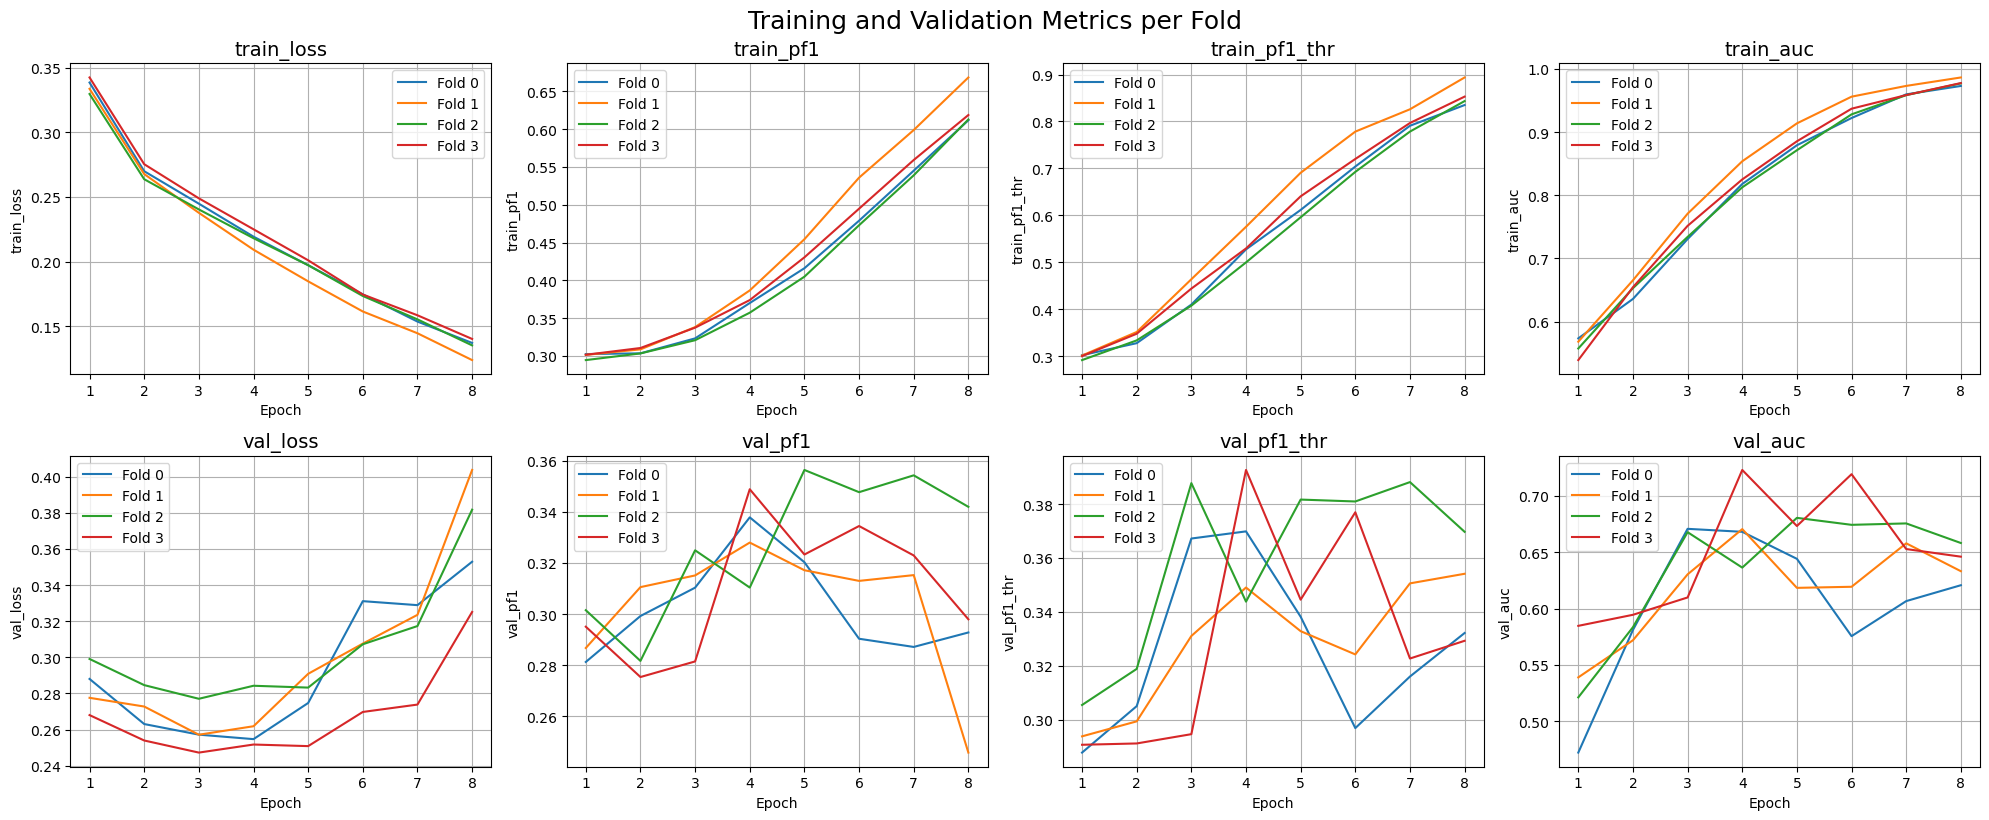

In [17]:
results_df = pd.read_csv("cv_epoch_results.csv")

metrics = [
    'train_loss', 'train_pf1', 'train_pf1_thr', 'train_auc',
    'val_loss', 'val_pf1', 'val_pf1_thr', 'val_auc']

# Set number of rows and columns for subplots
n_cols = 4
n_rows = (len(metrics) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    if metric not in results_df.columns:
        print(f"Warning: '{metric}' not found in DataFrame columns. Skipping.")
        ax.axis('off')
        continue
    for fold in sorted(results_df['fold'].unique()):
        fold_data = results_df[results_df['fold'] == fold]
        ax.plot(fold_data['epoch'], fold_data[metric], label=f"Fold {fold}")
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

# Hide unused axes
for i in range(len(metrics), len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.suptitle("Training and Validation Metrics per Fold", fontsize=18, y=1.02)
plt.savefig("metrics_per_fold.png")
plt.show()

### Grad-CAM Utility Functions

Provides tools to generate and visualize Grad-CAM heatmaps for the main cancer classification output:

---

**Function: `generate_gradcam_heatmap(model, image_tensor, target_layer)`**  
- Registers forward and backward hooks to capture:
  - **Activations** from the selected `target_layer`.
  - **Gradients** during the backward pass.
- Performs a forward pass to obtain the **cancer output**.
- Applies `sigmoid` and triggers `backward()` on the scalar prediction.
- Removes hooks and computes the Grad-CAM heatmap:
  - Averages gradients spatially to get importance weights.
  - Combines weights with feature activations.
  - Applies ReLU and normalizes the result.

**Returns**:
- The normalized heatmap.
- The predicted probability score for the cancer output.

---

**Function: `overlay_gradcam_on_image(original_img, heatmap, alpha=0.4)`**  
- Resizes the Grad-CAM heatmap to the original image size.
- Applies a JET color map to the heatmap.
- Overlays it with the original image using a transparency factor `alpha`.
- Converts the image back to RGB format.

**Returns**:
- An RGB image with the Grad-CAM heatmap visually overlaid for interpretation.

In [18]:
# --- GradCAM Utilities ---
def generate_gradcam_heatmap(model, image_tensor, target_layer):
    activations = []
    gradients = []

    def save_features_hook(module, input, output):
        activations.append(output.detach())

    def save_gradients_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    forward_hook = target_layer.register_forward_hook(save_features_hook)
    backward_hook = target_layer.register_full_backward_hook(save_gradients_hook)

    model.zero_grad()
    cancer_output, _ = model(image_tensor.unsqueeze(0))
    pred_score = torch.sigmoid(cancer_output)
    pred_score.backward()

    forward_hook.remove()
    backward_hook.remove()

    gradients_data = gradients[0].squeeze(0).cpu().numpy()
    activations_data = activations[0].squeeze(0).cpu().numpy()

    weights = np.mean(gradients_data, axis=(1, 2))
    cam = np.sum(weights[:, np.newaxis, np.newaxis] * activations_data, axis=0)

    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-7)
    return cam, pred_score.item()

def overlay_gradcam_on_image(original_img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    colored_heatmap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    original_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
    overlay_bgr = cv2.addWeighted(colored_heatmap, alpha, original_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    return overlay_rgb



### Summary: Test Evaluation and Grad-CAM Visualization

Performs final evaluation on the held-out test set and visualizes sample predictions with Grad-CAM overlays.

---

**1. Test DataLoader**  
- Constructs `test_dataset` using `test_df` with no augmentation.
- Wraps it in a `DataLoader` for batch inference.

**2. Load Best Model**  
- Loads the model architecture and weights from the best fold checkpoint.
- Sets the model to evaluation mode.

**3. Inference and Prediction Collection**  
- Runs inference without gradient tracking.
- Uses AMP (`autocast`) for efficiency.
- Applies `sigmoid` to model output and stores predictions and true labels.

**4. Save and Evaluate Predictions**  
- Adds predictions and true labels to `test_df`.
- Computes probabilistic F1 (pF1), best thresholded F1, and AUC using `compute_metrics`.
- Saves full test predictions to `test_predictions.csv`.

---

**5. Grad-CAM Visualization on Sample Predictions**  
- Sorts `test_df` by predicted cancer probability.
- Selects three samples: lowest, middle, highest prediction.
- For each:
  - Loads and preprocesses the image.
  - Computes Grad-CAM using the second-to-last block of the model.
  - Overlays the heatmap on the image using JET color map.
  - Displays predictions and ground truth as subplot titles.

- Saves visualization to `test_sample_predictions_with_gradcam.png`.

Testing on test split: 100%|██████████| 87/87 [00:20<00:00,  4.25it/s]



--- TEST RESULTS ---
AUC:        0.7176
pF1 (prob): 0.3559
pF1 (thr):  0.4079
Test predictions saved to test_predictions.csv
Sample test predictions with GradCAM saved to test_sample_predictions_with_gradcam.png


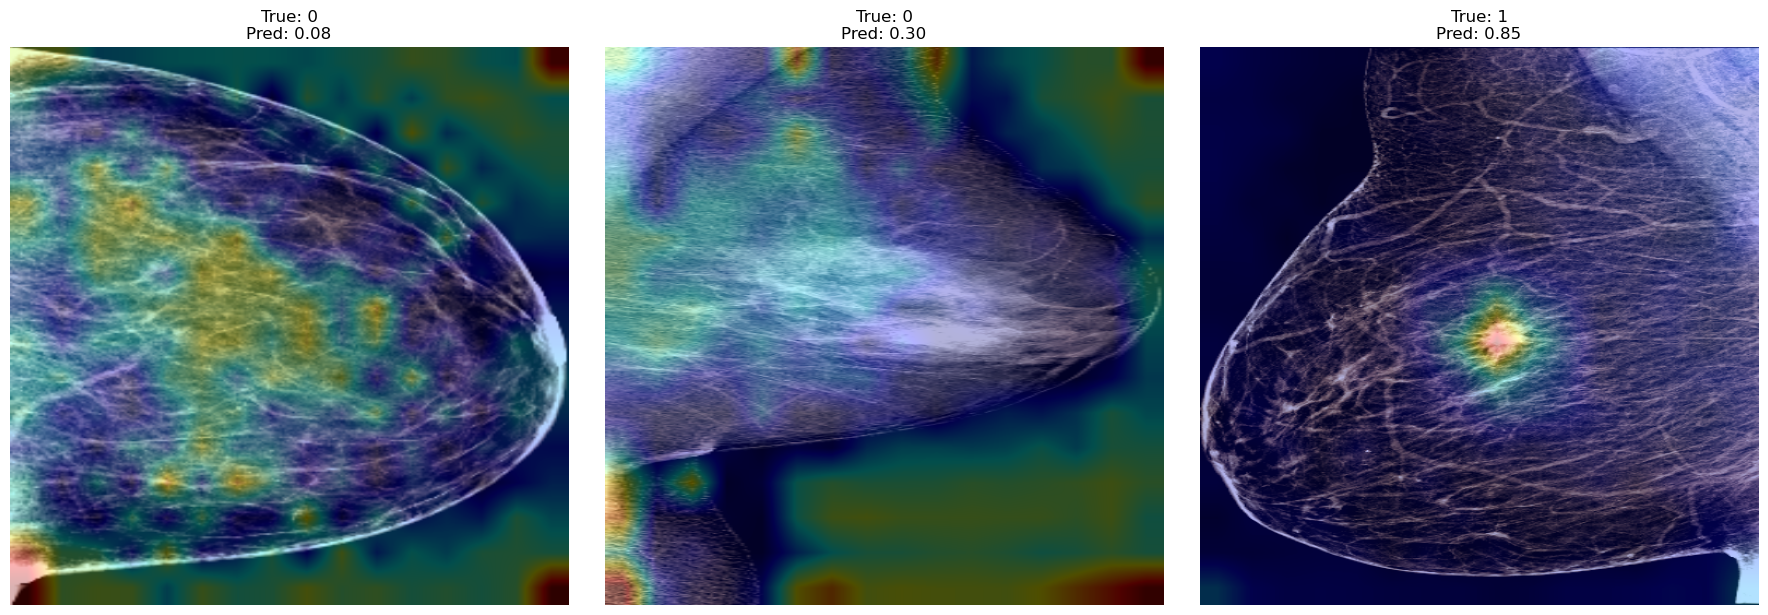

In [19]:
# --- Build test dataset and loader ---
test_dataset = BreastCancerDataset(test_df, transform=build_transforms(False))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=8)

# --- Load best model ---
model = BCModel(CFG.model_name, aux_targets_dims=AUX_TARGET_NCLASSES).to(device)
model.load_state_dict(torch.load(best_fold_model_path))
model.eval()

# --- Store test predictions ---
all_preds = []
all_targets = []

with torch.no_grad():
    for images, (cancer_targets, aux_targets) in tqdm(test_loader, desc="Testing on test split"):
        images = images.to(device)
        cancer_targets = cancer_targets.to(device)
    
        with autocast(device_type='cuda'):
            cancer_outputs, _ = model(images)
    
        preds = torch.sigmoid(cancer_outputs).detach().cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(cancer_targets.cpu().numpy())

# --- Save predictions to test_df ---
test_df['pred'] = all_preds
test_df['target'] = all_targets


# --- Compute metrics ---
pf1, best_thr_f1, auc, _ = compute_metrics(test_df['pred'].values, test_df['target'].values)

print(f"\n--- TEST RESULTS ---")
print(f"AUC:        {auc:.4f}")
print(f"pF1 (prob): {pf1:.4f}")
print(f"pF1 (thr):  {best_thr_f1:.4f}")

test_df.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to test_predictions.csv")

# --- Visualization of 3 samples with GradCAM ---
# Sort by prediction probability
sorted_df = test_df.sort_values(by="pred").reset_index(drop=True)

# Get lowest, middle, and highest predictions
lowest  = sorted_df.iloc[0]
middle  = sorted_df.iloc[len(sorted_df) // 2]
highest = sorted_df.iloc[-1]

# Combine into DataFrame
sampled = pd.DataFrame([lowest, middle, highest])
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, row in enumerate(sampled.itertuples()):
    img = cv2.imread(row.image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, CFG.img_size[::-1])

    img_tensor = torch.tensor(img_resized / 255.0, dtype=torch.float32).permute(2, 0, 1).to(device)

    target_layer = model.backbone.blocks[-2]
    heatmap, _ = generate_gradcam_heatmap(model, img_tensor, target_layer)

    overlay = overlay_gradcam_on_image(img_resized, heatmap, alpha=0.3)

    axs[i].imshow(overlay)
    axs[i].axis('off')
    axs[i].set_title(f"True: {int(row.target)}\nPred: {row.pred:.2f}", fontsize=12)

plt.tight_layout()
plt.savefig("test_sample_predictions_with_gradcam.png")
print("Sample test predictions with GradCAM saved to test_sample_predictions_with_gradcam.png")